In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
import warnings
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
from warnings import filterwarnings
filterwarnings('ignore')


In [ ]:
# Path of file to read
data_path = 'CollegeBasketballPlayers2009-2021.csv'
total_ball_data = pd.read_csv(data_path, low_memory = False)
total_ball_data = total_ball_data.drop(['ht', 'yr', 'num', 'pid', 'type', 'Rec Rank', 'gbpm', 'ogbpm', 'dgbpm', 'Unnamed: 64', 'Unnamed: 65'], axis=1)


Zmiana zmiennej objasnianej 'pick' na zmienna binarna i filtracja danych

In [19]:
#Przerabiam dane - zmienną objasniana pick przerabiam na binarną
total_ball_data["pick"] = total_ball_data["pick"].replace(np.nan, 0)
for i in range(len(total_ball_data)):
    if total_ball_data["pick"][i] >=1:
        total_ball_data["pick"][i]=1

total_ball_data['pick'] = total_ball_data['pick'].astype(int)

#filtruje przez te 3 kolumny zeby nie stracic zbyt duzej liczby zmiennych objasniajacych 
# w ten sposob tracę 9 a nie 34 zmiennych objasniajacych
total_ball_data =total_ball_data[total_ball_data['drtg'].notna()]
total_ball_data =total_ball_data[total_ball_data['ast'].notna()]
total_ball_data =total_ball_data[total_ball_data['dunksmade'].notna()]

total_ball_data['rimmade/(rimmade+rimmiss)'].fillna(0, inplace=True)
total_ball_data['midmade/(midmade+midmiss)'].fillna(0, inplace=True)
total_ball_data['dunksmade/(dunksmade+dunksmiss)'].fillna(0, inplace=True)
total_ball_data['ast/tov'].fillna(0, inplace=True)

total_ball_data = total_ball_data._get_numeric_data()

Na danych do 2020 roku włącznie uczę model. Na danych z 2021 dokonam weryfikacji modelu. 

In [21]:
ball_data = total_ball_data.loc[total_ball_data['year'] < 2021]
ball_data = ball_data.drop(['year'], axis=1)
ball_data_2021 = total_ball_data.loc[total_ball_data['year'] == 2021]
ball_data_2021 = ball_data_2021.drop(['year'], axis=1)
total_ball_data = total_ball_data.drop(['year'], axis=1)
#ball_data

In [36]:
def conf_matrix(val_y, pred_test):    
    # Creating a confusion matrix
    con_mat = confusion_matrix(val_y, pred_test)
    con_mat = pd.DataFrame(con_mat, index=['Not Drafted', 'Drafted'], columns=['Not Drafted', 'Drafted'])
    
    # Plotting the confusion matrix
    plt.figure(figsize=(6, 6))
    sn.set(font_scale=1.5)
    sn.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Adding labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

Wszystkie 45 zmiennych

In [23]:
# Creates a target object for the pick and calls it y
y = ball_data.pick

# Creates X by using specific statistics
#features = ['Min_per', 'ftr', 'pts', 'ORB_per', 'DRB_per', 'blk_per', 'stl_per', 'dporpag', 'porpag', 'AST_per', 'TO_per', 'FT_per']

X = ball_data.loc[:,ball_data.columns!='pick']

colnames=list(X)
#display(X)
#X = ball_data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

Validation f1 score: 0.24629
Validation recall score: 0.87578
Validation presision score: 0.14329


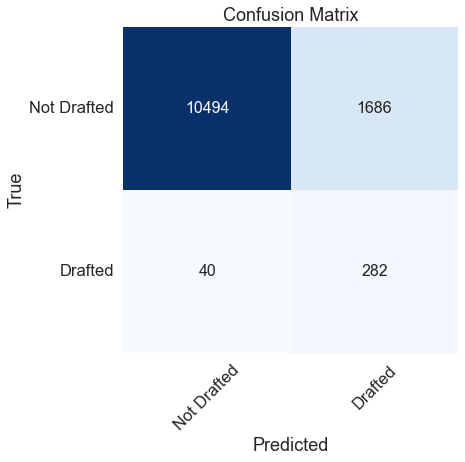

In [47]:
model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

model.fit(train_X, train_y)

y_pred = model.predict(val_X)

f1 = f1_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
print("Validation f1 score: {:,.5f}".format(f1))
print("Validation recall score: {:,.5f}".format(recall))
print("Validation presision score: {:,.5f}".format(precision))
 
conf_matrix(val_y, y_pred)


Validation f1 score: 0.13764
Validation recall score: 1.00000


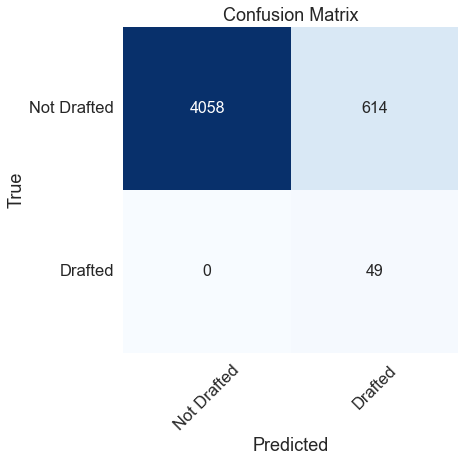

In [39]:
# Test data, using 2021
test_X_2021 = ball_data_2021[colnames]

# Make predictions
test_preds_2021 = model.predict(test_X_2021)

f1 = f1_score(ball_data_2021.pick, test_preds_2021)
recall = recall_score(ball_data_2021.pick, test_preds_2021)
print("Validation f1 score: {:,.5f}".format(f1))
print("Validation recall score: {:,.5f}".format(recall))
 
conf_matrix(ball_data_2021.pick, test_preds_2021)

# Save predictions in right format
#output = pd.DataFrame({'Name': ball_data_2021.player_name, 'Pick': test_preds_2021, 'Actual Pick' : ball_data_2021.pick})
#output = output.astype({'Pick':'int'})
#output = output.astype({'Actual Pick':'int'})
#output.to_csv('predictions2021.csv', index=False)
#output

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Text(0.5, 1.0, 'Scoring for different class weights')

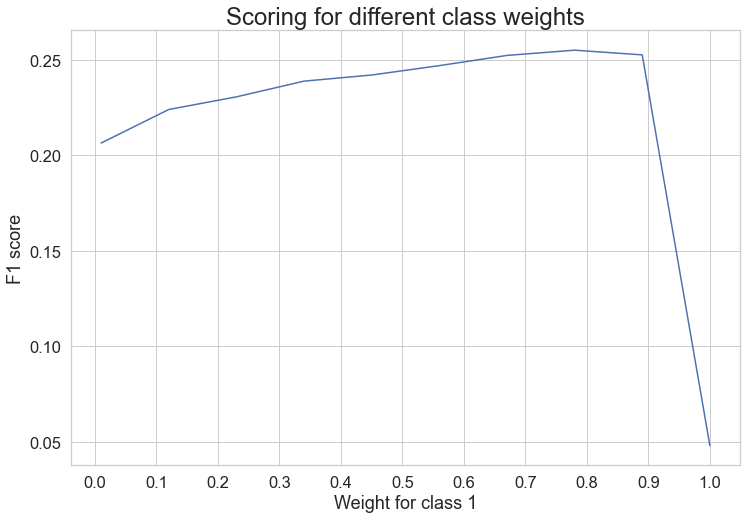

In [42]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,10)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= model, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(train_X, train_y)

#Ploting the score for different values of weight
sn.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sn.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)
# Get the index of the highest F1 score
best_index = gridsearch.best_index_

# Get the corresponding weight values for weight one and weight two
best_weight_one = 1 - weights[best_index]
best_weight_two = weights[best_index]

# Get the highest F1 score
best_f1_score = gridsearch.cv_results_['mean_test_score'][best_index]

# Print the results
print("Highest F1 Score:", best_f1_score)
print("Weight for Class 1:", best_weight_one)
print("Weight for Class 2:", best_weight_two)

Nowy model dla nowych wag

Validation f1 score: 0.36486
Validation recall score: 0.25155


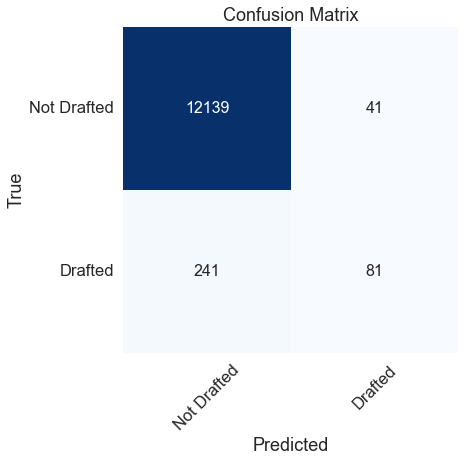

In [45]:
model = RandomForestClassifier(class_weight={0: 0.78, 1: 0.22})
# Fit the model with the specified class weights
model.fit(train_X, train_y)
y_pred = model.predict(val_X)

f1 = f1_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)
print("Validation f1 score: {:,.5f}".format(f1))
print("Validation recall score: {:,.5f}".format(recall))
 
conf_matrix(val_y, y_pred)


Check importance of features in Random Forest Model

    Feature     Score
0         0  0.150252
1         1  0.018884
2         2  0.008979
3         3  0.022111
4         4  0.000000
5         5  0.019726
6         6  0.013352
7         7  0.037942
8         8  0.003124
9         9  0.031726
10       10  0.022563
11       11  0.005763
12       12  0.000000
13       13  0.067118
14       14  0.013761
15       15  0.008651
16       16  0.008895
17       17  0.042738
18       18  0.003233
19       19  0.025698
20       20  0.024277
21       21  0.032236
22       22  0.334709
23       23  0.057738
24       24  0.009358
25       25  0.037169


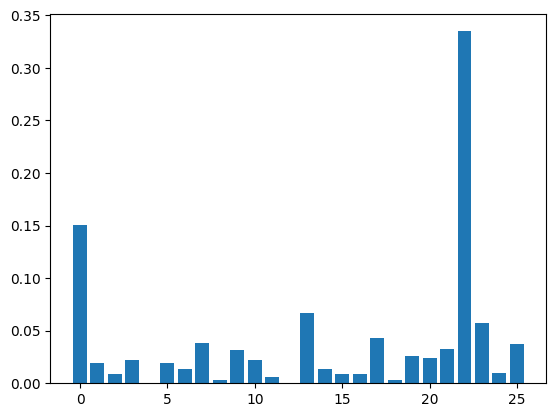

In [382]:
importance = model.feature_importances_
importancedf = pd.DataFrame(columns=['Feature', 'Score'])
for i,v in enumerate(importance):
    #print('Feature: %0d, Score: %.5f' % (i,v))
    importancedf = importancedf.append({'Feature':round(i), 'Score':v}, ignore_index=True)
    importancedf = importancedf.astype({'Feature':'int'})
print(importancedf)
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Choose top 11 features with highest importance


In [383]:
featurelist = list(X)

featuresdf = pd.DataFrame({'Feature': importancedf.iloc[:,0], 'Name': featurelist, 'Score':importancedf.iloc[:,1]})
featuresdf = featuresdf.sort_values(by=['Score'], ascending=False)
featuresdf.head(11)

,Feature,Name,Score
22,22,porpag,0.334709
0,0,GP,0.150252
13,13,twoPM,0.067118
23,23,adjoe,0.057738
17,17,TPA,0.042738
7,7,DRB_per,0.037942
25,25,pid,0.037169
21,21,ftr,0.032236
9,9,TO_per,0.031726
19,19,blk_per,0.025698


In [387]:
# Creates a target object for the pick and calls it y
y = ball_data.pick

# Creates X by using specific statistics
#features = ['gbpm', 'blk_per', 'twoPM', 'bpm', 'pid', 'DRB_per', 'ogbpm', 'ast', 'TPM', 'adjoe', 'Ortg']
features = ['porpag', 'GP', 'twoPM', 'adjoe', 'TPA', 'DRB_per', 'pid', 'ftr', 'TO_per', 'blk_per', 'stl_per']
Xnew = ball_data[features]

# Split into validation and training data
train_Xnew, val_Xnew, train_y, val_y = train_test_split(Xnew, y, random_state=1)

In [388]:
# Specify a Random Forest Model
ball_model = DecisionTreeRegressor(max_leaf_nodes=100, splitter='random', random_state=1, max_features='auto')
# Fit the model
ball_model.fit(train_Xnew, train_y)

# Make predictions on validation data and calculate the mean absolute error
val_preds = ball_model.predict(val_Xnew)
val_mae = mean_absolute_error(val_preds, val_y)
print("Validation MAE: {:,.5f}".format(val_mae))

Validation MAE: 1.38249


In [390]:
# Test data, using 2021
ball_data_2021 = total_ball_data.loc[total_ball_data['year'] == 2021]
test_X_2021 = ball_data_2021[features]

# Make predictions
test_preds_2021 = ball_model.predict(test_X_2021)

# Find MAE
test_mae_2021 = mean_absolute_error(test_preds_2021, ball_data_2021.pick)

print("2021 Test MAE: {:,.5f}".format(test_mae_2021))

# Save predictions in right format
output = pd.DataFrame({'Name': ball_data_2021.player_name, 'Pick': test_preds_2021, 'Actual Pick' : ball_data_2021.pick})
#output.to_csv('predictions2021.csv', index=False)
output = output.astype({'Pick':'int'})
output = output.astype({'Actual Pick':'int'})
output


2021 Test MAE: 0.84331


,Name,Pick,Actual Pick
56091,Troy Holston,0,0
56092,Isaiah Felder,0,0
56093,Thomas Bruce,0,0
56094,Tyler Underwood,0,0
56095,Jalen Coleman-Lands,0,0
...,...,...,...
61056,Trey Patterson,0,0
61057,Stavros Polatoglou,0,0
61058,Sandy Ryan,0,0
61059,Ty Larson,0,0


3rd method - SelectFromModel

In [391]:
# Creates a target object for the pick and calls it y
y = ball_data.pick

# Creates X by using specific statistics
#features = ['Min_per', 'ftr', 'pts', 'ORB_per', 'DRB_per', 'blk_per', 'stl_per', 'dporpag', 'porpag', 'AST_per', 'TO_per', 'FT_per']
data = ball_data._get_numeric_data()
X = data.loc[:,data.columns!='pick']
X = X[X.columns[:-1]]
X=X.dropna(axis=1)

display(X)
#X = ball_data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,porpag,adjoe,pfr,year,pid
0,26,29.5,97.3,16.6,42.5,44.43,1.6,4.6,15.8,16.3,10,14,0.714,26,68,0.382,13,39,0.333,0.3,1.5,13.1,0.258086,89.3938,2.5,2009,2
1,34,60.9,108.3,14.9,52.4,54.48,3.8,6.3,13.6,19.8,30,45,0.667,56,113,0.496,20,51,0.392,1.0,1.1,27.4,1.334920,100.0660,3.4,2009,3
2,27,72.0,96.2,21.8,45.7,47.98,2.1,8.0,14.7,15.9,45,67,0.672,67,157,0.427,50,154,0.325,0.0,0.9,21.5,2.274070,104.1070,1.7,2009,5
3,30,44.5,97.7,16.0,53.6,53.69,4.1,9.4,13.7,23.8,14,27,0.519,25,63,0.397,28,62,0.452,0.8,1.9,21.6,0.552857,93.2086,2.0,2009,8
4,33,56.2,96.5,22.0,52.8,54.31,8.3,18.6,8.2,22.7,64,114,0.561,93,176,0.528,0,0,0.000,1.9,1.3,64.8,1.060130,97.8554,3.8,2009,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56086,1,0.1,0.0,48.9,0.0,0.00,0.0,0.0,0.0,0.0,0,0,0.000,0,1,0.000,0,0,0.000,0.0,0.0,0.0,-0.414715,-34.1733,0.0,2020,72218
56087,1,0.2,206.9,35.9,100.0,102.56,0.0,0.0,0.0,0.0,2,2,1.000,1,1,1.000,0,0,0.000,0.0,0.0,200.0,0.998677,229.2430,0.0,2020,72219
56088,1,0.6,48.5,28.9,0.0,52.63,0.0,15.9,0.0,52.9,2,4,0.500,0,0,0.000,0,0,0.000,0.0,0.0,0.0,-0.685731,57.1100,5.7,2020,72220
56089,1,0.1,300.0,20.0,150.0,150.00,0.0,0.0,0.0,0.0,0,0,0.000,0,0,0.000,1,1,1.000,0.0,0.0,0.0,0.631560,267.3470,0.0,2020,72223


In [396]:
y = ball_data.pick
model = RandomForestClassifier(n_estimators = 100)
for i in [5,7,9,11]:

    sel = SelectFromModel(model, max_features=i)
    sel.fit(train_X, train_y)
    filter1 = sel.get_support()
    selected_feat= train_X.columns[(filter1)]
    print(len(selected_feat))
    print(list(selected_feat))
    #pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

    XX = ball_data[list(selected_feat)]
    train_XX, val_XX, train_y, val_y = train_test_split(XX, y, random_state=1)
    print(train_XX)
    print(train_y)


    # Specify a Random Forest Model
    ball_model = DecisionTreeRegressor(max_leaf_nodes=100, splitter='random', random_state=1, max_features='auto')

    # Fit the model
    ball_model.fit(train_XX, train_y)

    # Make predictions on validation data and calculate the mean absolute error
    val_preds = ball_model.predict(val_XX)
    val_mae = mean_absolute_error(val_preds, val_y)
    print("Validation MAE: {:,.5f}".format(val_mae))


    # Test data, using 2021
    ball_data_2021 = total_ball_data.loc[total_ball_data['year'] == 2021]
    test_X_2021 = ball_data_2021[list(selected_feat)]

    # Make predictions
    test_preds_2021 = ball_model.predict(test_X_2021)

    # Find MAE
    test_mae_2021 = mean_absolute_error(test_preds_2021, ball_data_2021.pick)

    # Save predictions in right format
    output = pd.DataFrame({'Name': ball_data_2021.player_name, 'Pick': test_preds_2021, 'Actual Pick' : ball_data_2021.pick})
    #output.to_csv('predictions2021.csv', index=False)
    output = output.astype({'Pick':'int'})
    output = output.astype({'Actual Pick':'int'})
    output

    print("2021 Test MAE: {:,.5f}".format(test_mae_2021))

5
['GP', 'blk_per', 'porpag', 'adjoe', 'pid']
       GP  blk_per    porpag     adjoe    pid
41900  32      2.2 -0.599182   75.5429  52006
12452  29      8.4  0.173371   87.1474  16508
8232   30      1.4  1.372660  102.6510  13259
38369  31      1.6  0.919834   99.2605  35960
50277  31      2.4  0.576339   97.5958  66263
...    ..      ...       ...       ...    ...
50057   7      0.0 -0.035245   77.3012  66018
32511  29      0.0 -1.111070   64.2384  20787
5192   28      1.0  0.221107   88.4348   1859
12172  11      6.3 -0.775629   33.7027  15700
33003  29      0.6  3.711450  118.4000  27498

[42068 rows x 5 columns]
41900    0.0
12452    0.0
8232     0.0
38369    0.0
50277    0.0
        ... 
50057    0.0
32511    0.0
5192     0.0
12172    0.0
33003    0.0
Name: pick, Length: 42068, dtype: float64
Validation MAE: 1.41225
2021 Test MAE: 1.01314
7
['GP', 'twoPM', 'twoPA', 'blk_per', 'porpag', 'adjoe', 'pid']
       GP  twoPM  twoPA  blk_per    porpag     adjoe    pid
41900  32     61    

KeyboardInterrupt: 

Wykres walidacji i testu dla MAE

       GP  blk_per    porpag     adjoe    pid
41900  32      2.2 -0.599182   75.5429  52006
12452  29      8.4  0.173371   87.1474  16508
8232   30      1.4  1.372660  102.6510  13259
38369  31      1.6  0.919834   99.2605  35960
50277  31      2.4  0.576339   97.5958  66263
...    ..      ...       ...       ...    ...
50057   7      0.0 -0.035245   77.3012  66018
32511  29      0.0 -1.111070   64.2384  20787
5192   28      1.0  0.221107   88.4348   1859
12172  11      6.3 -0.775629   33.7027  15700
33003  29      0.6  3.711450  118.4000  27498

[42068 rows x 5 columns] trainXX
41900    0.0
12452    0.0
8232     0.0
38369    0.0
50277    0.0
        ... 
50057    0.0
32511    0.0
5192     0.0
12172    0.0
33003    0.0
Name: pick, Length: 42068, dtype: float64 train_y


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

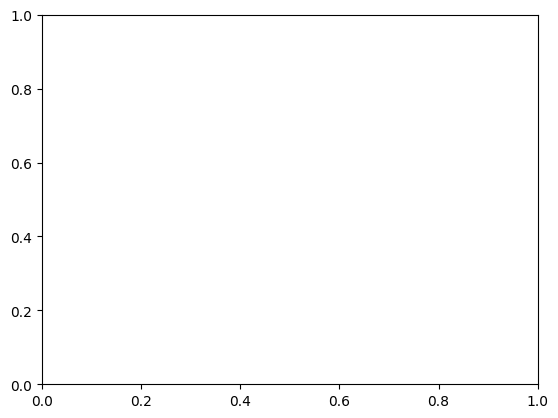

In [399]:
y = ball_data.pick
model = RandomForestClassifier(n_estimators = 100)
max_features_values = range(10)
val_mae_values = []
test_mae_values = []

#for i in max_features_values:
sel = SelectFromModel(model, max_features=5)
sel.fit(train_X, train_y)
filter1 = sel.get_support()
selected_feat= train_X.columns[(filter1)]
XX = ball_data[list(selected_feat)]
train_XX, val_XX, train_y, val_y = train_test_split(XX, y, random_state=1)
print(train_XX, 'trainXX')
print(train_y, 'train_y')
ball_model = DecisionTreeRegressor(max_leaf_nodes=100, splitter='random', random_state=1, max_features='auto')
ball_model.fit(train_XX, train_y)
val_preds = ball_model.predict(val_XX)
val_mae = mean_absolute_error(val_preds, val_y)
val_mae_values.append(val_mae)
# Test data, using 2021
ball_data_2021 = total_ball_data.loc[total_ball_data['year'] == 2021]
test_X_2021 = ball_data_2021[list(selected_feat)]
test_preds_2021 = ball_model.predict(test_X_2021)
test_mae_2021 = mean_absolute_error(test_preds_2021, ball_data_2021.pick)
test_mae_values.append(test_mae_2021)

plt.plot(max_features_values, val_mae_values, label='Validation MAE')
plt.plot(max_features_values, test_mae_values, label='Test MAE')
plt.legend()
plt.xlabel('max_features')
plt.ylabel('MAE')
plt.title('Validation and Test MAE for different values of max_features')
plt.show()

kom to u góry: jak widac mae dla validacji waha sie w okolicach 15, ale dla testu jest bardzo zmienny tzn trudno przewidziec tym modelem kto zostanie koszyrzaem NBA.

zestawienie rzeczywistych wartosci z predykcjami, jak widac mae 14 to bardzo duzo i wykresy walidacyjny i testowy sa bardzo rozporoszone czyli model nie jest za dobry - bylby dobry gdyby wykresy mialy ksztalt y=x

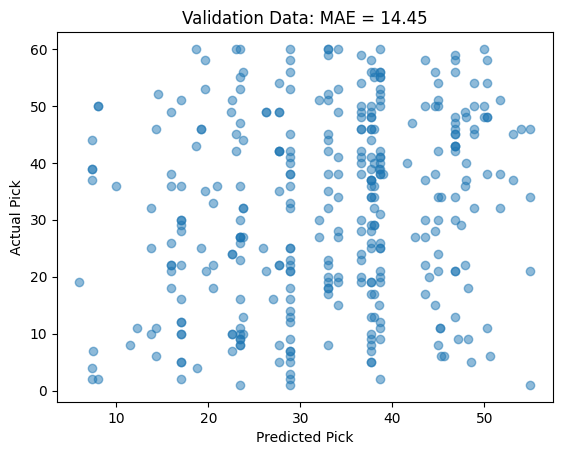

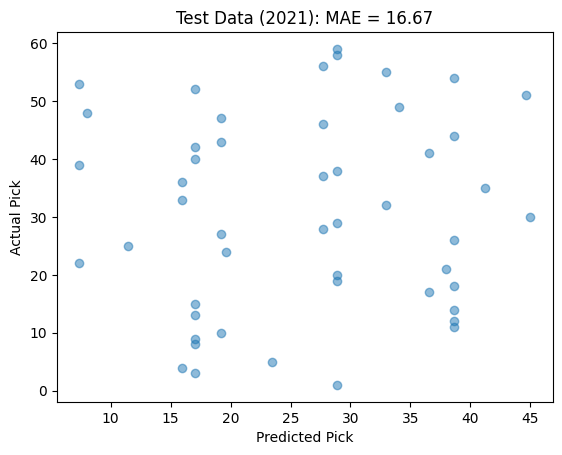

In [266]:
# Validation data
val_preds = ball_model.predict(val_XX)
val_mae = mean_absolute_error(val_preds, val_y)
plt.scatter(val_preds, val_y, alpha=0.5)
plt.xlabel('Predicted Pick')
plt.ylabel('Actual Pick')
plt.title('Validation Data: MAE = {:.2f}'.format(val_mae))
plt.show()

# Test data, using 2021
test_X_2021 = ball_data_2021[list(selected_feat)]
test_preds_2021 = ball_model.predict(test_X_2021)
test_mae_2021 = mean_absolute_error(test_preds_2021, ball_data_2021.pick)
plt.scatter(test_preds_2021, ball_data_2021.pick, alpha=0.5)
plt.xlabel('Predicted Pick')
plt.ylabel('Actual Pick')
plt.title('Test Data (2021): MAE = {:.2f}'.format(test_mae_2021))
plt.show()